This code takes the object initialization and force constant calculation part of the crystalline silicon example and proceeds to calculate $\kappa$ at a variety of temperatures.

## Write forcefield file


In [1]:
%%writefile Si.tersoff
# DATE: 2007-10-25 CONTRIBUTOR: Aidan Thompson, athomps@sandia.gov CITATION: Tersoff, Phys Rev B, 37, 6991 (1988)

# Tersoff parameters for various elements and mixtures
# multiple entries can be added to this file, LAMMPS reads the ones it needs
# these entries are in LAMMPS "metal" units:
#   A,B = eV; lambda1,lambda2,lambda3 = 1/Angstroms; R,D = Angstroms
#   other quantities are unitless

# This is the Si parameterization from a particular Tersoff paper:
# J. Tersoff, PRB, 37, 6991 (1988)
# See the SiCGe.tersoff file for different Si variants.

# format of a single entry (one or more lines):
#   element 1, element 2, element 3,
#   m, gamma, lambda3, c, d, costheta0, n, beta, lambda2, B, R, D, lambda1, A

Si     Si      Si        3.0 1.0 0.0 1.0039e5 16.217 -0.59825 0.78734 1.1000e-6  1.7322  471.18    2.85    0.15   2.4799  1830.8

Overwriting Si.tersoff


## Thermal transport simulation for silicon-bulk

In [ ]:
from ase.build import bulk
from ase.calculators.lammpslib import LAMMPSlib
from kaldo.forceconstants import ForceConstants
import numpy as np

# We start from the atoms object. use ASE to initialize a silicon diamond unit cell with FCC lattice parameter a.
atoms = bulk('Si', 'diamond', a=5.432)

# Config super cell and calculator input
# use a 3x3x3 supercell of unit cells.
# can also specify a supercell parameter exclusively for third-order force constants.
# additional supercells along for computing higher-order nearest-neighor terms. 
supercell = np.array([3, 3, 3])
lammps_inputs = {
      'lmpcmds': [
          'pair_style tersoff',
          'pair_coeff * * Si.tersoff Si'],

      'log_file': 'lammps-si-bulk.log',
      'keep_alive':True}

# Create a finite difference object
forceconstants_config  = {'atoms':atoms,'supercell': supercell,'folder':'fd'}
forceconstants = ForceConstants(**forceconstants_config)

# Compute 2nd and 3rd IFCs with LAMMPS using a tersoff potential
# delta_shift is how much to move atoms when computing forces
forceconstants.second.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)
forceconstants.third.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)



KeyboardInterrupt


KeyboardInterrupt



### Prepare phonon constants


In [3]:
from kaldo.phonons import Phonons

# Define k-point grids, temperature
# and the assumption for the
# phonon poluation (i.e classical vs. quantum)
k = 7
kpts = [k, k, k]
temperature = 300
is_classic = False # phonon mondes are treated as quantized
k_label = str(k) + '_' + str(k) + '_' + str(k)


### Calculate conductivities for infinite-size sample over varying temperatures with QHGK, Inversion & RTA BTE


In [8]:
from kaldo.conductivity import Conductivity

import logging
logging.basicConfig(level=logging.WARNING) # Set the root logger to DEBUG level

temperatures = np.linspace(200, 1000, 9) # K
cond_matrices_rtaq = []
kappa_rtaq = []
cond_matrices_invq = []
kappa_invq = []

for T in temperatures:
    # Create a phonon object
    phonons = Phonons(forceconstants=forceconstants,
                    kpts=kpts,
                    is_classic=is_classic,
                    temperature=T,
                    folder='si-bulk-ald-' + k_label,
                    storage='numpy')
    
    # compute conductivity with full scattering matrix inversion
    print('\n')
    inv_cond_matrix = (Conductivity(phonons=phonons, method='inverse').conductivity.sum(axis=0))
    cond_inv = np.mean(np.diag(inv_cond_matrix))
    print('Inverted conductivity (W/mK): %.3f'%(cond_inv))
    
    # Calculate conductivity  with  relaxation time approximation (rta), only considering diagonals of scattering matrix.
    # this effectively means we only consider energy -conserving three-phonon processes where the two initial (annihilation to 1 phonon)
    # or two final (one phonon decays into two) phonons have the momentum index and mode.
    print('\n')
    rta_cond_matrix = Conductivity(phonons=phonons, method='rta').conductivity.sum(axis=0)
    cond_rta = np.mean(np.diag(rta_cond_matrix))
    print('RTA conductivity (W/mK): %.3f'%(cond_rta))

    qhgk_cond_matrix = Conductivity(phonons=phonons, method='qhgk').conductivity.sum(axis=0)

    # extract values of interest from resultant thermal conductivity matrices
    cond = np.mean(np.diag(qhgk_cond_matrix))
    cond_matrices.append(qhgk_cond_matrix)
    kappa.append(cond)
    print(f'QHGK conductivity (W/mK): {cond:.3f}')
    
    
    cond_matrices_rtaq.append(rta_cond_matrix)
    kappa_rtaq.append(cond_rta)
    cond_matrices_invq.append(inv_cond_matrix)
    kappa_invq.append(cond_inv)
    print(f'QHGK conductivity (W/mK): {cond:.3f}')



2025-10-16 11:07:19,390 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/200/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/200/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:07:19,395 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/200/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/200/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:07:19,410 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:07:19,426 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:07:19,429 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:07:19,443 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:07:19,446 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:07:19,460 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/population


2025-10-16 11:07:55,046 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:07:57,257 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:07:57,631 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:07:57,635 - kaldo - INFO - Memory needed: 33 MB, available: 2882 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 2882 / 16890 MB


2025-10-16 11:08:12,779 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:08:12,838 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:08:12,840 - kaldo - INFO - Memory needed: 33 MB, available: 3228 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3228 / 16890 MB


2025-10-16 11:08:12,871 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


2025-10-16 11:08:13,857 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:13,860 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:08:13,902 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:08:13,941 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:08:13,943 - kaldo - INFO - Memory needed: 33 MB, available: 3227 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3227 / 16890 MB


2025-10-16 11:08:13,953 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


2025-10-16 11:08:14,867 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:14,870 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:08:14,892 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:08:14,938 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:08:14,941 - kaldo - INFO - Memory needed: 33 MB, available: 3236 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3236 / 16890 MB


2025-10-16 11:08:14,950 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


2025-10-16 11:08:15,956 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/200/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/200/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:08:16,486 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/200/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/200/quantum/heat_capacity stored


2025-10-16 11:08:16,490 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:16,494 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:16,499 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 495.570


2025-10-16 11:08:16,590 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:08:16,595 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/200/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/200/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:08:16,600 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/200/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/200/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:08:16,604 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:16,607 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:16,610 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/bandwidth


2025-10-16 11:08:16,661 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/200/quantum/heat_capacity


2025-10-16 11:08:16,666 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:16,670 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:16,674 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 443.909
QHGK conductivity (W/mK): 70.860


2025-10-16 11:08:16,772 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/288/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/288/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:08:16,776 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/288/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/288/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:08:16,780 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:16,785 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:16,789 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:16,792 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:08:16,796 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:08:16,835 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/population


2025-10-16 11:08:19,072 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:08:21,127 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:08:21,485 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:08:21,493 - kaldo - INFO - Memory needed: 33 MB, available: 2986 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 2986 / 16890 MB


2025-10-16 11:08:36,087 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:08:36,121 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:08:36,123 - kaldo - INFO - Memory needed: 33 MB, available: 3251 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3251 / 16890 MB


2025-10-16 11:08:36,144 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


2025-10-16 11:08:37,009 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:37,011 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:08:37,046 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:08:37,077 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:08:37,079 - kaldo - INFO - Memory needed: 33 MB, available: 3249 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3249 / 16890 MB


2025-10-16 11:08:37,088 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


2025-10-16 11:08:37,938 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:37,941 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:08:37,959 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:08:37,992 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:08:37,994 - kaldo - INFO - Memory needed: 33 MB, available: 3248 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3248 / 16890 MB


2025-10-16 11:08:38,003 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


2025-10-16 11:08:38,946 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/288/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/288/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:08:39,498 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/288/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/288/quantum/heat_capacity stored


2025-10-16 11:08:39,502 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:39,505 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:39,510 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 304.267


2025-10-16 11:08:39,610 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:08:39,615 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/288/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/288/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:08:39,619 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/288/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/288/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:08:39,623 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:39,625 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:39,629 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/bandwidth


2025-10-16 11:08:39,686 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/288/quantum/heat_capacity


2025-10-16 11:08:39,691 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:39,695 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:39,700 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 270.410
QHGK conductivity (W/mK): 70.860


2025-10-16 11:08:39,789 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/377/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/377/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:08:39,793 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/377/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/377/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:08:39,796 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:39,800 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:08:39,803 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:08:39,806 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:08:39,809 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:08:39,829 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/population


2025-10-16 11:08:42,153 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:08:44,095 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:08:44,423 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:08:44,426 - kaldo - INFO - Memory needed: 33 MB, available: 3096 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3096 / 16890 MB


2025-10-16 11:08:59,213 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:08:59,244 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:08:59,246 - kaldo - INFO - Memory needed: 33 MB, available: 3309 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3309 / 16890 MB


2025-10-16 11:08:59,270 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


2025-10-16 11:09:00,110 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:00,113 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:00,154 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:09:00,188 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:00,190 - kaldo - INFO - Memory needed: 33 MB, available: 3304 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3304 / 16890 MB


2025-10-16 11:09:00,200 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


2025-10-16 11:09:01,028 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:01,032 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:01,049 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:09:01,079 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:01,081 - kaldo - INFO - Memory needed: 33 MB, available: 3299 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3299 / 16890 MB


2025-10-16 11:09:01,090 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


2025-10-16 11:09:01,986 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/377/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/377/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:09:02,431 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/377/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/377/quantum/heat_capacity stored


2025-10-16 11:09:02,436 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:02,440 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:02,445 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 222.109


2025-10-16 11:09:02,527 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:09:02,532 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/377/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/377/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:09:02,537 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/377/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/377/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:09:02,540 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:02,544 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:02,549 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/bandwidth


2025-10-16 11:09:02,606 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/377/quantum/heat_capacity


2025-10-16 11:09:02,611 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:02,615 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:02,619 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 196.448
QHGK conductivity (W/mK): 70.860


2025-10-16 11:09:02,703 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/466/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/466/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:09:02,708 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/466/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/466/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:09:02,712 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:02,716 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:02,720 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:02,723 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:02,727 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:09:02,746 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/population


2025-10-16 11:09:05,101 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:09:07,207 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:09:07,527 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:09:07,530 - kaldo - INFO - Memory needed: 33 MB, available: 2972 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 2972 / 16890 MB


2025-10-16 11:09:22,095 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:09:22,130 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:22,132 - kaldo - INFO - Memory needed: 33 MB, available: 3277 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3277 / 16890 MB


2025-10-16 11:09:22,152 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


2025-10-16 11:09:23,104 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:23,107 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:23,146 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:09:23,179 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:23,181 - kaldo - INFO - Memory needed: 33 MB, available: 3318 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3318 / 16890 MB


2025-10-16 11:09:23,191 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


2025-10-16 11:09:24,326 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:24,328 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:24,347 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:09:24,381 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:24,383 - kaldo - INFO - Memory needed: 33 MB, available: 3333 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3333 / 16890 MB


2025-10-16 11:09:24,392 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


2025-10-16 11:09:25,225 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/466/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/466/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:09:25,693 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/466/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/466/quantum/heat_capacity stored


2025-10-16 11:09:25,697 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:25,701 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:25,706 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 175.815


2025-10-16 11:09:25,809 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:09:25,814 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/466/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/466/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:09:25,820 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/466/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/466/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:09:25,825 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:25,829 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:25,834 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/bandwidth


2025-10-16 11:09:25,900 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/466/quantum/heat_capacity


2025-10-16 11:09:25,904 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:25,907 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:25,911 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 155.082
QHGK conductivity (W/mK): 70.860


2025-10-16 11:09:26,028 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/555/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/555/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:09:26,032 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/555/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/555/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:09:26,037 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:26,041 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:26,045 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:26,049 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:26,054 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:09:26,075 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/population


2025-10-16 11:09:28,527 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:09:30,574 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:09:30,958 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:09:30,966 - kaldo - INFO - Memory needed: 33 MB, available: 3026 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3026 / 16890 MB


2025-10-16 11:09:45,632 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:09:45,676 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:45,679 - kaldo - INFO - Memory needed: 33 MB, available: 3371 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3371 / 16890 MB


2025-10-16 11:09:45,707 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


2025-10-16 11:09:46,592 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:46,596 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:46,631 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:09:46,662 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:46,664 - kaldo - INFO - Memory needed: 33 MB, available: 3370 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3370 / 16890 MB


2025-10-16 11:09:46,672 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


2025-10-16 11:09:47,543 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:47,546 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:47,563 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:09:47,597 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:09:47,599 - kaldo - INFO - Memory needed: 33 MB, available: 3367 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3367 / 16890 MB


2025-10-16 11:09:47,609 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


2025-10-16 11:09:48,457 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/555/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/555/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:09:48,944 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/555/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/555/quantum/heat_capacity stored


2025-10-16 11:09:48,949 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:48,951 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:48,957 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 145.855


2025-10-16 11:09:49,051 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:09:49,056 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/555/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/555/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:09:49,060 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/555/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/555/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:09:49,064 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:49,068 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:49,072 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/bandwidth


2025-10-16 11:09:49,127 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/555/quantum/heat_capacity


2025-10-16 11:09:49,132 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:49,135 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:49,140 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 128.446
QHGK conductivity (W/mK): 70.860


2025-10-16 11:09:49,225 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/644/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/644/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:09:49,229 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/644/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/644/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:09:49,233 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:49,236 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:09:49,239 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:09:49,243 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:09:49,249 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:09:49,269 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/population


2025-10-16 11:09:51,604 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:09:53,620 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:09:54,017 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:09:54,022 - kaldo - INFO - Memory needed: 33 MB, available: 3158 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3158 / 16890 MB


2025-10-16 11:10:09,061 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:10:09,096 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:09,098 - kaldo - INFO - Memory needed: 33 MB, available: 3591 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3591 / 16890 MB


2025-10-16 11:10:09,120 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


2025-10-16 11:10:10,028 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:10,031 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:10,071 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:10:10,104 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:10,106 - kaldo - INFO - Memory needed: 33 MB, available: 3622 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3622 / 16890 MB


2025-10-16 11:10:10,116 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


2025-10-16 11:10:11,149 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:11,152 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:11,170 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:10:11,201 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:11,203 - kaldo - INFO - Memory needed: 33 MB, available: 3599 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3599 / 16890 MB


2025-10-16 11:10:11,211 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


2025-10-16 11:10:12,196 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/644/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/644/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:10:12,805 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/644/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/644/quantum/heat_capacity stored


2025-10-16 11:10:12,809 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:12,813 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:12,817 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 124.781


2025-10-16 11:10:12,902 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:10:12,906 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/644/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/644/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:10:12,912 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/644/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/644/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:10:12,915 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:12,919 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:12,922 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/bandwidth


2025-10-16 11:10:12,991 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/644/quantum/heat_capacity


2025-10-16 11:10:12,998 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:13,005 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:13,010 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 109.773
QHGK conductivity (W/mK): 70.860


2025-10-16 11:10:13,099 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/733/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/733/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:10:13,103 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/733/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/733/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:10:13,107 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:13,110 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:13,114 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:13,118 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:13,123 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:10:13,143 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/population


2025-10-16 11:10:15,374 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:10:17,640 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:10:18,073 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:10:18,081 - kaldo - INFO - Memory needed: 33 MB, available: 3154 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3154 / 16890 MB


2025-10-16 11:10:34,051 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:10:34,092 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:34,095 - kaldo - INFO - Memory needed: 33 MB, available: 3445 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3445 / 16890 MB


2025-10-16 11:10:34,115 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


2025-10-16 11:10:35,049 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:35,052 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:35,089 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:10:35,121 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:35,123 - kaldo - INFO - Memory needed: 33 MB, available: 3467 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3467 / 16890 MB


2025-10-16 11:10:35,132 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


2025-10-16 11:10:35,965 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:35,970 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:35,990 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:10:36,024 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:36,026 - kaldo - INFO - Memory needed: 33 MB, available: 3511 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3511 / 16890 MB


2025-10-16 11:10:36,036 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


2025-10-16 11:10:36,972 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/733/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/733/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:10:37,457 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/733/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/733/quantum/heat_capacity stored


2025-10-16 11:10:37,462 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:37,466 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:37,471 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 109.109


2025-10-16 11:10:37,559 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:10:37,564 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/733/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/733/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:10:37,568 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/733/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/733/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:10:37,571 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:37,574 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:37,578 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/bandwidth


2025-10-16 11:10:37,646 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/733/quantum/heat_capacity


2025-10-16 11:10:37,652 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:37,656 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:37,660 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 95.917
QHGK conductivity (W/mK): 70.860


2025-10-16 11:10:37,751 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/822/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/822/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:10:37,755 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/822/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/822/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:10:37,759 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:37,764 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:10:37,768 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:37,772 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:37,777 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:10:37,799 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/population


2025-10-16 11:10:40,117 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:10:42,078 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:10:42,405 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:10:42,414 - kaldo - INFO - Memory needed: 33 MB, available: 3142 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3142 / 16890 MB


2025-10-16 11:10:56,843 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:10:56,875 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:56,877 - kaldo - INFO - Memory needed: 33 MB, available: 3471 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3471 / 16890 MB


2025-10-16 11:10:56,897 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


2025-10-16 11:10:57,767 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:57,770 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:57,815 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:10:57,851 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:57,853 - kaldo - INFO - Memory needed: 33 MB, available: 3485 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3485 / 16890 MB


2025-10-16 11:10:57,866 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


2025-10-16 11:10:58,726 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:10:58,729 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:10:58,745 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:10:58,779 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:10:58,781 - kaldo - INFO - Memory needed: 33 MB, available: 3483 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3483 / 16890 MB


2025-10-16 11:10:58,791 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


2025-10-16 11:10:59,651 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/822/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/822/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:11:00,091 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/822/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/822/quantum/heat_capacity stored


2025-10-16 11:11:00,095 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:00,097 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:00,100 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 96.976


2025-10-16 11:11:00,166 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:11:00,169 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/822/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/822/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:11:00,172 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/822/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/822/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:11:00,174 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:00,177 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:00,179 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/bandwidth


2025-10-16 11:11:00,217 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/822/quantum/heat_capacity


2025-10-16 11:11:00,220 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:00,221 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:00,224 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 85.210
QHGK conductivity (W/mK): 70.860


2025-10-16 11:11:00,287 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/911/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/911/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:11:00,290 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/911/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/911/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:11:00,293 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:00,296 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:00,299 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:00,301 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:11:00,303 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:11:00,316 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/population


2025-10-16 11:11:02,665 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:11:04,773 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:11:05,106 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:11:05,114 - kaldo - INFO - Memory needed: 33 MB, available: 3153 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3153 / 16890 MB


2025-10-16 11:11:19,767 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:11:19,801 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:11:19,804 - kaldo - INFO - Memory needed: 33 MB, available: 3479 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3479 / 16890 MB


2025-10-16 11:11:19,826 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


2025-10-16 11:11:20,721 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:20,725 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:11:20,765 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:11:20,800 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:11:20,803 - kaldo - INFO - Memory needed: 33 MB, available: 3480 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3480 / 16890 MB


2025-10-16 11:11:20,813 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


2025-10-16 11:11:21,669 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:21,671 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:11:21,688 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:11:21,720 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:11:21,721 - kaldo - INFO - Memory needed: 33 MB, available: 3483 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3483 / 16890 MB


2025-10-16 11:11:21,732 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


2025-10-16 11:11:22,693 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/911/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/911/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2025-10-16 11:11:23,145 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/911/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/911/quantum/heat_capacity stored


2025-10-16 11:11:23,148 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:23,150 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:23,153 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 87.297


2025-10-16 11:11:23,214 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:11:23,217 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/911/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/911/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:11:23,220 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/911/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/911/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:11:23,222 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:23,224 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:23,227 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/bandwidth


2025-10-16 11:11:23,332 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/911/quantum/heat_capacity


2025-10-16 11:11:23,335 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:23,337 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:23,340 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 76.677
QHGK conductivity (W/mK): 70.860


2025-10-16 11:11:23,409 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/1000/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/1000/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:11:23,412 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/inverse/1000/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/inverse/1000/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:11:23,414 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:23,416 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:23,419 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:23,421 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:11:23,423 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2025-10-16 11:11:23,443 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/population


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/population


2025-10-16 11:11:25,174 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:11:27,303 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/_sparse_phase_and_potential


2025-10-16 11:11:27,636 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2025-10-16 11:11:27,639 - kaldo - INFO - Memory needed: 33 MB, available: 3152 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3152 / 16890 MB


2025-10-16 11:11:42,631 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor stored


2025-10-16 11:11:42,666 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:11:42,668 - kaldo - INFO - Memory needed: 33 MB, available: 3472 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3472 / 16890 MB


2025-10-16 11:11:42,694 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


2025-10-16 11:11:43,565 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:43,568 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:11:43,604 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:11:43,637 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:11:43,638 - kaldo - INFO - Memory needed: 33 MB, available: 3489 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3489 / 16890 MB


2025-10-16 11:11:43,648 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


2025-10-16 11:11:44,514 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:44,516 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2025-10-16 11:11:44,533 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/_ps_gamma_and_gamma_tensor


2025-10-16 11:11:44,565 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2025-10-16 11:11:44,566 - kaldo - INFO - Memory needed: 33 MB, available: 3494 / 16890 MB


INFO:kaldo:Memory needed: 33 MB, available: 3494 / 16890 MB


2025-10-16 11:11:44,575 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


2025-10-16 11:11:45,526 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/heat_capacity


2025-10-16 11:11:45,529 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:45,532 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:45,534 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverted conductivity (W/mK): 79.390


2025-10-16 11:11:45,602 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.


2025-10-16 11:11:45,605 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/1000/quantum/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/1000/quantum/conductivity not found in formatted format, calculating conductivity


2025-10-16 11:11:45,609 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/rta/1000/quantum/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/rta/1000/quantum/mean_free_path not found in formatted format, calculating mean_free_path


2025-10-16 11:11:45,612 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:45,615 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:45,617 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/bandwidth


2025-10-16 11:11:45,643 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/1000/quantum/heat_capacity


2025-10-16 11:11:45,646 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2025-10-16 11:11:45,649 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2025-10-16 11:11:45,652 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


RTA conductivity (W/mK): 69.713
QHGK conductivity (W/mK): 70.860


## Plotting

[445.84123334 439.78332804 446.10169495]
[271.49908194 268.13919407 271.59088795]
[197.20942463 194.87657783 197.25736077]
[155.67060523 153.87364905 155.7012577 ]
[128.92723106 127.46047348 128.94928865]
[110.18098427 108.93907703 110.19808478]
[96.27228368 95.19392029 96.28621862]
[85.52398221 84.57022872 85.53574129]
[76.95925065 76.10376918 76.96942948]
[69.9688334  69.19293766 69.97781485]


<>:12: SyntaxWarning: invalid escape sequence '\k'
<>:12: SyntaxWarning: invalid escape sequence '\k'
C:\Users\allen\AppData\Local\Temp\ipykernel_30468\3506764149.py:12: SyntaxWarning: invalid escape sequence '\k'
  ax.set_ylabel("$\kappa$ (W/mK)")


Text(0, 0.5, '$\\kappa$ (W/mK)')

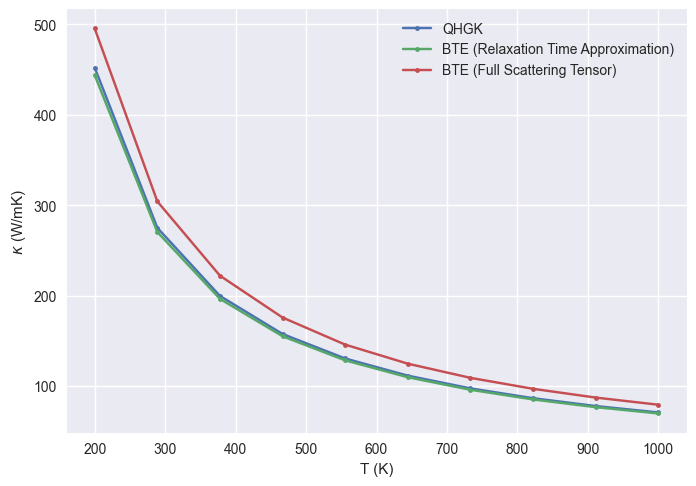

In [12]:
import matplotlib.pyplot as plt

for mat in cond_matrices_rtaq:
    print(np.diag(mat))

fig, ax = plt.subplots()
ax.plot(temperatures, kappa, marker=".", label="QHGK")
ax.plot(temperatures, kappa_rtaq, marker=".", label="BTE (Relaxation Time Approximation)")
ax.plot(temperatures, kappa_invq, marker=".", label="BTE (Full Scattering Tensor)")
ax.legend(loc="upper right")
ax.set_xlabel("T (K)")
ax.set_ylabel("$\kappa$ (W/mK)")


For reference, these are the temperature-dependent heat conductivities calculated in the kALDO paper:
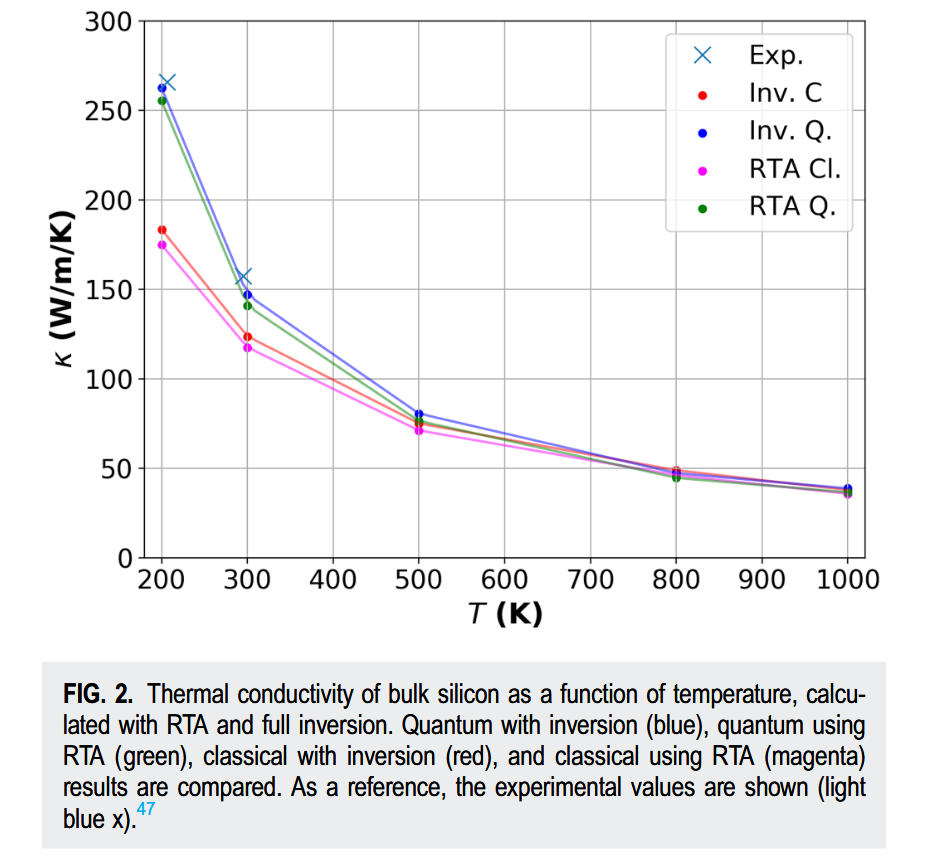

Our computed results are roughly off by a factor of two\
We are sampling a limited amount of k-points right now ((7,7,7) vs (19,19,19)). In addition, the paper calculates 2nd-order force constants with DFT, and third-order IFCs with finite-difference displacement on a (5,5,5) supercell. The tutorial code we are using calculates both force constants on a (3,3,3) supercell using molecular dynamics (LAMMPS).

I don't know how to run DFT right now and so am stuck with LAMMPS, but expect the current results to somewhat converge to the papers' if i increase the supercell size and k-sampling points.

**From the kALDO AIP paper:**
"We compute the thermal conductivity of diamond silicon at
room temperature as a first benchmark of κALDo with first-
principles DFT. We calculated the second order IFC using Density
Functional Perturbation Theory as implemented in the Quantum-
Espresso package,44 using the local density approximation (LDA)
for the exchange and correlation functional and a Bachelet-
Hamann-Schluter norm-conserving pseudopotential.45 Kohn-Sham
orbitals are represented on a plane waves basis set with a cutoff of
20 Ry and (8, 8, 8) k-points mesh. The minimized lattice parameter
is 5:398 Å. The third-order IFC is calculated using finite difference
displacement on (5, 5, 5) replicas of the irreducible fcc unit cell,
including up to the fifth nearest neighbor. The phonon lifetimes
and thermal conductivity calculations were performed with
κALDo, using a (19, 19, 19) q-point grid."